In [1]:
import pandas as pd

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

class PIDVelocityController:
    def __init__(self, p=0.1, i=0.01, d=0.05, max_output=2.0, min_output=-2.0, inertia=1.0):
        self.p = p
        self.i = i
        self.d = d
        self.max_output = max_output
        self.min_output = min_output
        self.prev_error = 0.0
        self.integral = 0.0
        self.inertia = inertia  # Moment of inertia (affects acceleration response)

    def compute_move(self, target_velocity, current_velocity) -> float:
        """ Computes torque output to adjust velocity using PID control. """
        error = target_velocity - current_velocity
        self.integral += error
        derivative = error - self.prev_error
        output = self.p * error + self.i * self.integral + self.d * derivative
        self.prev_error = error
        return np.clip(output, self.min_output, self.max_output) # Outputs the 

    def simulate_response(self, target_velocity, time_steps=200, dt=0.1):
        """ Simulates response and returns a performance score based on overshoot, stability, and settling time. """
        velocity = 0
        total_error = 0
        stability_penalty = 0
        overshoot_penalty = 0
        response = []
        
        for _ in range(time_steps):
            torque = self.compute_move(target_velocity, velocity)
            acceleration = torque / self.inertia
            velocity += acceleration * dt
            response.append(velocity)
            
            error = abs(target_velocity - velocity)
            total_error += error  # Minimize steady-state error
            
            if velocity > 1.2 * target_velocity:  # Penalize overshoot beyond 20%
                overshoot_penalty += abs(velocity - target_velocity)
                
            if len(response) > 10 and abs(response[-1] - response[-10]) > 0.05 * target_velocity:
                stability_penalty += 1  # Penalize oscillations
            
        return total_error + 5 * overshoot_penalty + 2 * stability_penalty  # Weighted cost function

    def auto_tune(self, target_velocity, show_graph=False, verbose=False):
        """ Auto-tunes PID gains for velocity control by minimizing the error-based cost function. """
        search_space = {
            "p": np.linspace(0.01, 20.0, 10),
            "i": np.linspace(0.001, 10.0, 10),
            "d": np.linspace(0.01, 20.0, 10)
        }

        best_p, best_i, best_d = self.p, self.i, self.d
        best_error = float('inf')

        # Initial search for a rough estimate
        for p, i, d in itertools.product(search_space["p"], search_space["i"], search_space["d"]):
            self.p, self.i, self.d = p, i, d
            error = self.simulate_response(target_velocity)
            if error < best_error:
                best_p, best_i, best_d = p, i, d
                best_error = error
                if verbose:
                    print(f"New best: P={p:.3f}, I={i:.3f}, D={d:.3f}, Error={error:.2f}")

        # Refine search around the best values
        search_space_refined = {
            "p": np.linspace(max(0.01, best_p * 0.8), best_p * 1.2, 5),
            "i": np.linspace(max(0.001, best_i * 0.8), best_i * 1.2, 5),
            "d": np.linspace(max(0.01, best_d * 0.8), best_d * 1.2, 5)
        }

        for p, i, d in itertools.product(search_space_refined["p"], search_space_refined["i"], search_space_refined["d"]):
            self.p, self.i, self.d = p, i, d
            error = self.simulate_response(target_velocity)
            if error < best_error:
                best_p, best_i, best_d = p, i, d
                best_error = error
                if verbose:
                    print(f"Refined best: P={p:.3f}, I={i:.3f}, D={d:.3f}, Error={error:.2f}")

        # Apply optimized values
        self.p, self.i, self.d = best_p, best_i, best_d
        print(f"Optimized PID values: P={self.p:.3f}, I={self.i:.3f}, D={self.d:.3f}")

        # Show graph if requested
        if show_graph:
            self.plot_response(target_velocity)

    def plot_response(self, target_velocity, time_steps=500, dt=0.1):
        """ Plots the system's velocity response with the optimized PID values. """
        velocity = 0
        response = []
        
        for _ in range(time_steps):
            torque = self.compute_move(target_velocity, velocity)
            acceleration = torque / self.inertia
            velocity += acceleration * dt
            response.append(velocity)

        plt.figure(figsize=(10, 5))
        plt.plot(response, label="Velocity Response")
        plt.axhline(y=target_velocity, color='r', linestyle='--', label="Target Velocity")
        plt.xlabel("Time")
        plt.ylabel("Velocity")
        plt.title("PID Velocity Response")
        plt.legend()
        plt.show()


Stable oscillations detected: Kp=1.4000000000000004, Tu=2.000000000000001, Aplitudes=[0.022128122304439835, 0.014293287073624317, 0.0020304242753410584, 0.015155677379511179, 0.02010495483361252, 0.0011427127041527818, 0.01727921546029787, 0.023209920321212163, 0.014144216827319589, 0.012609450476440909, 0.006539672619023662, 0.008321245786530262, 0.010472245187563622, 0.0029876561875621377, 0.0239057512670815, 0.007230571246175543, 0.014801760520779084, 0.0019321077358425143, 0.015493722171739055, 0.02002247514684008, 0.003133951412694902, 0.017877606659383094, 0.024532393443344347, 0.01736106019296546, 0.018565573422661075]
Amplitude ratio: 1.5481478956141093
Tuned PID values: Kp=0.12918662394374492, Ki=0.12918662394374486, Kd=0.08603829154653417


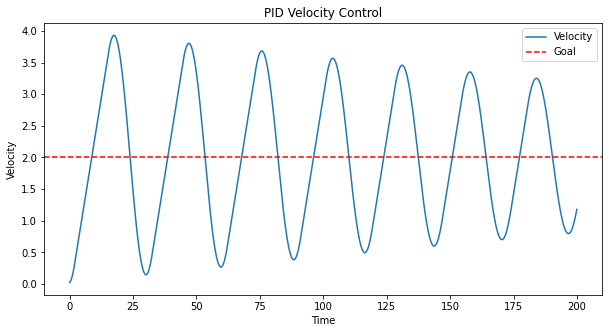

In [ ]:
start = 0
goal = 2
actual = 0
moment_of_inertia = 2
dt = 0.1

class NewPID:
    def __init__(self, intertia, dt=0.01, max_torque = 5):
        self.intertia = intertia
        self.kp = 1
        self.ki = .1
        self.kd = 3
        self.integral = 0.0
        self.prev_error = 0.0
        self.actual_velocity = 0.0
        self.dt = dt
        self.max_torque = max_torque

    
    def newton_second_law(self, torque):
        """ Computes acceleration based on Newton's second law of motion. """
        output = min(self.max_torque, torque) / self.intertia
        return output

    def simulate_motion(self, required_velocity):
        """ Simulates motion based on the torque input and updates the required_velocity. """
        acceleration = self.newton_second_law(self.compute_value_based_on_pid(required_velocity))
        self.actual_velocity += acceleration * self.dt
        return self.actual_velocity

    def compute_value_based_on_pid(self, required_velocity, update_values=True):
        """ Computes the PID value based on the error and the PID constants. """
        error = required_velocity - self.actual_velocity
        derivative = (error - self.prev_error) / self.dt if self.dt > 0 else 0

        if update_values:
            self.integral += error
            self.prev_error = error
        output = self.kp * error + self.ki * self.integral + self.kd * derivative
        return output
    
    def auto_tune(self, goal, max_time=10, auto_accept = True):
        """Auto-tunes PID using Ziegler-Nichols method."""
        temp_kp = self.kp
        temp_ki = self.ki
        temp_kd = self.kd

        prev_velocity = 0
        oscillations = []
        amplitudes = []

        Ku = None # unlimited gain
        Tu = None

        # Ramp up Kp until stable oscillations occur
        while temp_kp < 200:  
            self.actual_velocity = 0
            velocity_data = []
            time = np.arange(0, max_time, self.dt)
            
            for t in time:
                velocity = self.simulate_motion(goal)
                velocity_data.append(velocity)

                # Detect zero crossings for oscillation period
                if prev_velocity < goal and velocity >= goal:
                    if len(oscillations) > 1:
                        Tu = t - oscillations[-1] # Oscillation period
                    oscillations.append(t)
                    amplitudes.append((velocity - goal))

                prev_velocity = velocity
            
            # Check if oscillations have formed
            if len(oscillations) > 20 and Tu is not None:
                print(f"Stable oscillations detected: Kp={temp_kp}, Tu={Tu}, Aplitudes={(amplitudes)}")
                # Compute the amplitude ratio
                amp_ratio = amplitudes[0] / amplitudes[1]
                print(f"Amplitude ratio: {amp_ratio}")
                Ku = 1/amp_ratio  # Ultimate gain
                break

            temp_kp += 0.1  # Increment Kp to find Ku

        if Ku is None or Tu is None:
            print("Auto-tuning failed: No stable oscillations detected.")
            return
        
        # Apply Ziegler-Nichols tuning rules (Classic PID)
        temp_kp = 0.2 * Ku
        temp_ki = 0.4 * Ku / Tu
        temp_kd = 0.0666 * Ku * Tu

        print(f"Tuned PID values: Kp={temp_kp}, Ki={temp_ki}, Kd={temp_kd}")

        if auto_accept:
            self.kp = temp_kp
            self.ki = temp_ki
            self.kd = temp_kd

    def reset(self):
        """Resets the PID controller."""
        self.integral = 0.0
        self.prev_error = 0.0
        self.actual_velocity = 0.0



pid = NewPID(moment_of_inertia)
pid.auto_tune(goal)
pid.reset()
time = np.arange(0, 200, dt)
data = []

# Try and run the simulation
for _ in time:
    actual = pid.simulate_motion(goal)
    data.append(actual)

# Create a Graph
plt.figure(figsize=(10, 5))
plt.plot(time, data, label="Velocity")
plt.axhline(y=goal, color='r', linestyle='--', label="Goal")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("PID Velocity Control")
plt.legend()
plt.show()

